In [1]:
from pathlib import Path
from Bio.PDB import PDBList, PDBParser
import os
from tqdm import tqdm
import warnings
import pandas as pd
from Bio import SeqIO
from dotenv import load_dotenv
import os
import requests
import time
import json
from Bio.PDB.ic_rebuild import structure_rebuild_test
import numpy as np
import seaborn as sns
from Bio.Align import PairwiseAligner
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import statsmodels.api as sm
import re
from sklearn.decomposition import PCA
from scipy.stats import linregress
load_dotenv();

In [262]:
WINDOW_SIZE = 5
WINDOW_SIZE_CONTEXT = 6
PDBMINE_URL = os.getenv("PDBMINE_URL")
figure_dir = Path('5-15_figures')

# casp_protein_id = 'T1038'   # 6ya2
# casp_protein_id = 'T1056'   # 6yj1
# casp_protein_id = 'T1028'   # pdb code '6vqp' - dont use for regr
# casp_protein_id = 'T1025'

# casp_protein_id = 'T1024'   # pdb code '6t1z' - dont use for regr
# casp_protein_id = 'T1030'   # 6poo
# casp_protein_id = 'T1049'   # 6y4f - short sequence
# casp_protein_id = 'T1058'   # 7abw 
casp_protein_id = 'T1091'   # 7w6b
# casp_protein_id = 'T1031'   # 
# casp_protein_id = 'T1082'   # 
# casp_protein_id = 'T1096'   # 

In [366]:
amino_acid_codes = json.load(open('amino_acid_codes.json'))

targetlist_url = 'https://predictioncenter.org/casp14/targetlist.cgi?type=csv'
targetlist_file = Path('targetlist.csv')
if not targetlist_file.exists():
    with open(targetlist_file, 'wb') as f:
        f.write(requests.get(targetlist_url).content)
targetlist = pd.read_csv(targetlist_file, sep=';').set_index('Target')
def get_pdb_code(x):
    m = re.search(r"\b\d[0-9a-z]{3}\b", x)
    return m.group() if m else ''        
targetlist['pdb_code'] = targetlist['Description'].apply(get_pdb_code)

pdb_code = targetlist.loc[casp_protein_id].pdb_code
print('PDB:', pdb_code)
alphafold_id = f'{casp_protein_id}TS427_1'
outdir = Path(f'tests/{casp_protein_id}_win{WINDOW_SIZE}-{WINDOW_SIZE_CONTEXT}')
if outdir.exists():
    print('Results already exist')
else:
    outdir.mkdir(exist_ok=False, parents=True)

# Get X-ray pdb
pdbl = PDBList()
parser = PDBParser()
xray_fn = pdbl.retrieve_pdb_file(pdb_code, pdir='pdb', file_format='pdb', obsolete=False)

# Get CASP predictions
predictions_url = f'https://predictioncenter.org/download_area/CASP14/predictions/regular/{casp_protein_id}.tar.gz'
predictions_dir = Path(f'./casp-predictions/')
if not (predictions_dir / casp_protein_id).exists():
    predictions_dir.mkdir(exist_ok=True)
    os.system(f'wget -O {predictions_dir}/{casp_protein_id}.tar.gz {predictions_url}')
    os.system(f'tar -xvf {predictions_dir}/{casp_protein_id}.tar.gz -C {predictions_dir}')

# Get CASP results
results_url = 'https://predictioncenter.org/download_area/CASP14/results/tables/casp14.res_tables.T.tar.gz'
results_dir = Path('casp-results')
if not results_dir.exists():
    results_dir.mkdir(exist_ok=True)
    os.system(f'wget -O {results_dir / "casp14.res_tables.T.tar.gz"} {results_url}')
    os.system(f'tar -xvf {results_dir / "casp14.res_tables.T.tar.gz"} -C {results_dir}')
results_file = results_dir / f'{casp_protein_id}.txt'
if not results_file.exists():
    results_file = Path(results_dir / f'{casp_protein_id}-D1.txt')
results = pd.read_csv(results_file, sep='\s+')
results = results[results.columns[1:]]
results['Model'] = results['Model'].apply(lambda x: x.split('-')[0])

def get_center(seq):
    if WINDOW_SIZE % 2 == 0:
        return seq[WINDOW_SIZE // 2 - 1]
    else:
        return seq[-WINDOW_SIZE // 2]
def get_seq(i):
    if WINDOW_SIZE % 2 == 0:
        if WINDOW_SIZE_CONTEXT % 2 == 0:
            return slice(i-WINDOW_SIZE//2+1,i+WINDOW_SIZE//2+1)
        return slice(i-WINDOW_SIZE//2,i+WINDOW_SIZE//2)
    else:
        return slice(i-WINDOW_SIZE//2,i+WINDOW_SIZE//2+1)
def get_seq_ctxt(i):
    if WINDOW_SIZE_CONTEXT % 2 == 0:
        return slice(i-WINDOW_SIZE_CONTEXT//2+1,i+WINDOW_SIZE_CONTEXT//2+1)
    return slice(i-WINDOW_SIZE_CONTEXT//2,i+WINDOW_SIZE_CONTEXT//2+1)
def get_subseq(seq):
    if WINDOW_SIZE % 2 == 0:
        return seq[WINDOW_SIZE_CONTEXT//2 - WINDOW_SIZE//2:WINDOW_SIZE_CONTEXT//2 + WINDOW_SIZE//2]
    else:
        if WINDOW_SIZE_CONTEXT % 2 == 0:
            return seq[WINDOW_SIZE_CONTEXT//2 - WINDOW_SIZE//2-1:WINDOW_SIZE_CONTEXT//2 + WINDOW_SIZE//2]
        return seq[WINDOW_SIZE_CONTEXT//2 - WINDOW_SIZE//2:WINDOW_SIZE_CONTEXT//2 + WINDOW_SIZE//2 + 1]
    
phi_psi_mined = pd.read_csv(outdir / f'phi_psi_mined_win{WINDOW_SIZE}.csv')
phi_psi_mined_ctxt = pd.read_csv(outdir / f'phi_psi_mined_win{WINDOW_SIZE_CONTEXT}.csv')
phi_psi_predictions = pd.read_csv(outdir / 'phi_psi_predictions.csv')
xray_phi_psi = pd.read_csv(outdir / 'xray_phi_psi.csv')
overlapping_seqs = list(set(phi_psi_mined_ctxt.seq) & set(phi_psi_predictions.seq_ctxt) & set(xray_phi_psi.seq_ctxt))
seqs = phi_psi_predictions.seq_ctxt.unique()
protein_ids = phi_psi_predictions.protein_id.unique()
phi_psi_predictions = pd.read_csv(outdir / f'phi_psi_predictions_md-kmeans.csv')
xray_phi_psi = pd.read_csv(outdir / f'xray_phi_psi_md-kmeans.csv')

# kmeans
def find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, bw_method, kdews):
    # combine with weights
    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])

    # Find probability of each point
    kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T, weights=phi_psi_dist['weight'], bw_method=bw_method)
    most_likely = phi_psi_dist.iloc[kernel(phi_psi_dist[['phi', 'psi']].values.T).argmax()]
    phi_psi_dist['prob'] = kernel(phi_psi_dist[['phi', 'psi']].values.T)

    # cluster with kmeans
    max_sil_avg = -1
    for k in range(2, min(phi_psi_dist.shape[0], 7)):
        kmeans = KMeans(n_clusters=k, n_init=10)
        labels = kmeans.fit_predict(phi_psi_dist[['phi', 'psi']])
        sil_avg = silhouette_score(phi_psi_dist[['phi', 'psi']], labels)
        if sil_avg > max_sil_avg:
            max_sil_avg = sil_avg
            phi_psi_dist['cluster'] = labels
    
    # Find most probable cluster
    c = phi_psi_dist.groupby('cluster').sum(numeric_only=True)
    phi_psi_dist_c = phi_psi_dist[phi_psi_dist.cluster == c.prob.idxmax()]
    if phi_psi_dist_c.shape[0] < 3:
        print('Too few points in cluster - using entire dist')
        phi_psi_dist_c = phi_psi_dist

    print('Chosen dist:', phi_psi_dist_c[['phi', 'psi']].shape, phi_psi_dist.phi.mean(), phi_psi_dist.psi.mean())    
    return phi_psi_dist, phi_psi_dist_c, most_likely

# X-means
# def find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews):
#     pass

def calc_maha_for_one(phi_psi: np.ndarray, phi_psi_dist: np.ndarray, kdepeak):    
    cov = np.cov(phi_psi_dist.T)
    if np.diag(cov).min() < 1:
        print('No significant variance in distribution - using distance to kde peak')
        return np.sqrt((phi_psi[0] - kdepeak[0])**2 + (phi_psi[1] - kdepeak[1])**2)
    if np.linalg.det(cov) == 0:
        print('Singular covariance matrix - using distance to kde peak')
        return np.sqrt((phi_psi[0] - kdepeak[0])**2 + (phi_psi[1] - kdepeak[1])**2)
    
    icov = np.linalg.inv(cov)
    mean = phi_psi_dist.mean(axis=0)
    return np.sqrt((phi_psi - mean) @ icov @ (phi_psi - mean).T)

def calc_maha(phi_psi_preds, phi_psi_dist, kdepeak):
    cov = np.cov(phi_psi_dist.T)
    if np.diag(cov).min() < 1:
        print('No significant variance in distribution - using distance to kde peak')
        return np.sqrt(((phi_psi_preds[:,0] - kdepeak[0])**2) + ((phi_psi_preds[:,1] - kdepeak[1])**2))
    if np.linalg.det(cov) == 0:
        print('Singular covariance matrix - using distance to kde peak')
        return np.sqrt(((phi_psi_preds[:,0] - kdepeak[0])**2) + ((phi_psi_preds[:,1] - kdepeak[1])**2))
    
    icov = np.linalg.inv(cov)
    diff = phi_psi_preds - phi_psi_dist.mean(axis=0)
    return np.sqrt((np.expand_dims((diff), 1) @ icov @ np.expand_dims((diff), 2)).squeeze())

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
kdews = [1,128]
def plot_one_dist(seq, pred_id, pred_name=None, axlims=None, bw_method=None):
    pred_name = pred_name or pred_id
    inner_seq = get_subseq(seq)
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == inner_seq].copy()
    phi_psi_ctxt_dist = phi_psi_mined_ctxt[phi_psi_mined_ctxt.seq == seq].copy()
    phi_psi_alpha = phi_psi_predictions[(phi_psi_predictions.protein_id == pred_id) & (phi_psi_predictions.seq_ctxt == seq)]
    xray_phi_psi_seq = xray_phi_psi[xray_phi_psi.seq_ctxt == seq]

    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])
    print(phi_psi_dist.groupby('weight').count().iloc[:,0].values)

    fig, ax = plt.subplots(figsize=(7,5))
    sns.scatterplot(data=phi_psi_ctxt_dist, x='phi', y='psi', ax=ax, color=colors[1],zorder=5, alpha=0.5, marker='.')
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', weights='weight', ax=ax, fill=True, color=colors[0], bw_method=bw_method)

    kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T, weights=phi_psi_dist['weight'], bw_method=bw_method)
    most_likely = phi_psi_dist.iloc[kernel(phi_psi_dist[['phi', 'psi']].values.T).argmax()]
    
    ax.plot(phi_psi_alpha.phi, phi_psi_alpha.psi, 'o', color=colors[2], label='AlphaFold Prediction', zorder=10)
    ax.plot(xray_phi_psi_seq.phi, xray_phi_psi_seq.psi, 'o', color=colors[3], label='X-ray', zorder=10)
    ax.scatter(most_likely.phi, most_likely.psi, color=colors[4], marker='x', label='KDE Peak', zorder=20)
    sns.scatterplot(data=phi_psi_predictions[phi_psi_predictions.seq_ctxt == seq], x='phi', y='psi', ax=ax, color='black', zorder=5, alpha=0.2, marker='.')

    ax.legend(handles=[
        mpatches.Patch(color=colors[0], label=f'Query for {inner_seq}'),
        mpatches.Patch(color=colors[1], label=f'Query for {seq}'),
        mpatches.Patch(color=colors[2], label=f'{pred_name} Prediction'),
        mpatches.Patch(color=colors[3], label='X-ray'),
        mpatches.Patch(color=colors[4], label='KDE Peak'),
        mpatches.Patch(color='black', label='Other Predictions')
    ])
    ax.set_title(f'PDBMine Distribution of Dihedral Angles for Resiude {seq[WINDOW_SIZE_CONTEXT//2]} of Window {seq}')

    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')

    if axlims:
        ax.set_xlim(axlims[0][0], axlims[0][1])
        ax.set_ylim(axlims[1][0], axlims[1][1])

    plt.tight_layout()
    plt.show()

def plot_one_dist_3d(seq, bw_method=None):
    inner_seq = get_subseq(seq)#seq[WINDOW_SIZE_CONTEXT // 2 - WINDOW_SIZE // 2:WINDOW_SIZE_CONTEXT // 2 + WINDOW_SIZE // 2 + 1]
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == inner_seq].copy()
    phi_psi_ctxt_dist = phi_psi_mined_ctxt[phi_psi_mined_ctxt.seq == seq].copy()

    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])

    x = phi_psi_dist[['phi','psi']].values.T
    weights = phi_psi_dist['weight'].values
    kde = gaussian_kde(x, weights=weights, bw_method=bw_method)

    x_grid, y_grid = np.meshgrid(np.linspace(-200, 200, 50), np.linspace(-200, 200, 50))
    grid = np.vstack([x_grid.ravel(), y_grid.ravel()])
    z = kde(grid).reshape(x_grid.shape)
    print(f'Max: P({grid[0,z.argmax()]}, {grid[1,z.argmax()]})={z.max()}')

    cm = plt.get_cmap('turbo')
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x_grid, y_grid, z, cmap=cm)
    ax.set_xlabel('Phi', fontsize=12, labelpad=10)
    ax.set_ylabel('Psi', fontsize=12, labelpad=10)
    ax.set_zlabel('Density', fontsize=12, labelpad=10)
    ax.set_title(f'PDBMine Distribution of Dihedral Angles\nfor Residue {seq[WINDOW_SIZE_CONTEXT//2]} of Window {seq}', y=0.99, fontsize=14)
    ax.dist = 12

    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.zaxis.set_tick_params(labelsize=10)

    plt.tight_layout()
    plt.savefig(figure_dir / '3d_dist.pdf', format='pdf', bbox_inches='tight', dpi=300)

# For one window
def plot_clusters_for_window(seq, pred_id, pred_name=None, eps=10, bw_method=0.1, kdews=None, axlims=None, zoom=False, zoom_lims=None):
    colors = sns.color_palette("bright")
    inner_seq = get_subseq(seq)
    kdews = kdews or [1,128]
    pred_name = pred_name or pred_id
    phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == inner_seq][['phi','psi']].copy()
    phi_psi_ctxt_dist = phi_psi_mined_ctxt.loc[phi_psi_mined_ctxt.seq == seq][['phi','psi']].copy()
    xray = xray_phi_psi[xray_phi_psi.seq_ctxt == seq]
    alpha = phi_psi_predictions[(phi_psi_predictions.protein_id == pred_id) & (phi_psi_predictions.seq_ctxt == seq)]
    preds = phi_psi_predictions[phi_psi_predictions.seq_ctxt == seq]
    alphafold = phi_psi_predictions[(phi_psi_predictions.protein_id == alphafold_id) & (phi_psi_predictions.seq_ctxt == seq)]

    if xray.shape[0] == 0:
        print('No xray data for this window')
        return
    if alpha.shape[0] == 0:
        print('No alpha data for this window')
        return
    if preds.shape[0] == 0:
        print('No predictions for this window')
        return
    
    pos = xray['pos'].values[0]

    print(inner_seq, phi_psi_dist.shape)
    print(seq, phi_psi_ctxt_dist.shape)

    phi_psi_dist, phi_psi_dist_c, most_likely = find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, bw_method, kdews)

    # Mahalanobis distance to most common cluster
    md_xray = calc_maha_for_one(xray[['phi','psi']].values[0], phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values)
    md_alpha = calc_maha_for_one(alpha[['phi','psi']].values[0], phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values)
    md_preds = calc_maha(preds[['phi','psi']].values, phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values)
    md_alphafold = calc_maha_for_one(alphafold[['phi','psi']].values[0], phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values)

    print('xray:', md_xray)
    print('alpha:', md_alpha)
    print('alphafold:', md_alphafold)
    print('preds:\n', pd.DataFrame(md_preds).describe())
    value_counts = phi_psi_dist.cluster.value_counts().sort_values(ascending=False)
    print(value_counts.to_dict())

    fig, ax = plt.subplots(figsize=(9,7))
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, levels=8, zorder=0, color='black')
    # ax.scatter(phi_psi_ctxt_dist.phi, phi_psi_ctxt_dist.psi, color='orange', marker='.', label=f'{seq} Query')
    ax.scatter(preds.phi, preds.psi, color='black', marker='o', s=5, alpha=0.2, label='All Other CASP-14 Predictions', zorder=1)
    ax.scatter(xray.phi, xray.psi, color=colors[1], marker='o', label='X-ray', zorder=10, s=100)
    ax.scatter(alpha.phi, alpha.psi, color=colors[2], marker='o', label=pred_name, zorder=10, s=100)
    ax.scatter(alphafold.phi, alphafold.psi, color=colors[4], marker='o', label='AlphaFold', zorder=10, s=100)
    ax.scatter(phi_psi_dist_c.phi.mean(), phi_psi_dist_c.psi.mean(), marker='x', label='Mean of Distribution', color='red', zorder=10, s=100)

    # dotted line from each point to mean
    ax.plot([xray.phi.values[0], phi_psi_dist_c.phi.mean()], [xray.psi.values[0], phi_psi_dist_c.psi.mean()], linestyle='dashed', color=colors[1], zorder=1, linewidth=1)
    ax.plot([alpha.phi.values[0], phi_psi_dist_c.phi.mean()], [alpha.psi.values[0], phi_psi_dist_c.psi.mean()], linestyle='dashed', color=colors[2], zorder=1, linewidth=1)
    ax.plot([alphafold.phi.values[0], phi_psi_dist_c.phi.mean()], [alphafold.psi.values[0], phi_psi_dist_c.psi.mean()], linestyle='dashed', color=colors[4], zorder=1, linewidth=1)

    ax.set_xlabel('Phi', fontsize=12)
    ax.set_ylabel('Psi', fontsize=12)
    res = phi_psi_predictions.loc[phi_psi_predictions.seq==inner_seq, 'res'].values[0]
    ax.set_title(r'Chosen Distribution of Dihedral Angles $D^{(i)}$ for Residue'+f' {res} of Window {seq}', fontsize=14) # 397
    ax.legend(loc='lower left')
    ax.set_xlim(-165, -35)
    ax.set_ylim(10, 205)
    plt.tight_layout()
    plt.savefig(figure_dir / 'md_dist.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Plot xray vs prediction md for each residue of one prediction
def plot_res_vs_md(pred_id, pred_name=None, highlight_res=None, limit_quantile=None):
    pred_name = pred_name or pred_id
    phi_psi_predictions['Source'] = 'CASP Prediction'
    phi_psi_predictions.loc[phi_psi_predictions.protein_id == pred_id, 'Source'] = pred_name
    alpha = phi_psi_predictions.loc[phi_psi_predictions.protein_id == pred_id]
    xray_phi_psi['Source'] = 'X-Ray'
    both = pd.merge(alpha, xray_phi_psi[['seq', 'md']], how='inner', on=['seq','seq'], suffixes=('_alpha','_xray'))
    both['md_diff'] = both['md_alpha'] - both['md_xray']
    both_limit = both.copy()
    if limit_quantile:
        both_limit[both_limit.md_alpha > both_limit.md_alpha.quantile(limit_quantile)] = np.nan
        both_limit[both_limit.md_xray > both_limit.md_xray.quantile(limit_quantile)] = np.nan
        both_limit[both_limit.md_diff > both_limit.md_diff.quantile(limit_quantile)] = np.nan
    
    sns.set_style("white")
    fig, axes = plt.subplots(2, figsize=(10, 5), sharex=True)
    sns.lineplot(data=both_limit.reset_index(), x='index', y='md_alpha', ax=axes[0], label=pred_name)
    sns.lineplot(data=both_limit.reset_index(), x='index', y='md_xray', ax=axes[0], label='Xray')
    axes[0].set_ylabel('')
    sns.lineplot(data=both_limit.reset_index(), x='index', y='md_diff', ax=axes[1], label=f'Difference:\n{pred_name} - Xray')
    axes[1].fill_between(x=both_limit.index, y1=both_limit['md_diff'].mean() + both_limit['md_diff'].std(), y2=both_limit['md_diff'].mean() - both_limit['md_diff'].std(), color='tan', alpha=0.4)
    axes[1].hlines(both_limit['md_diff'].mean(), xmin=0, xmax=len(both_limit), color='tan', label='Mean Difference', linewidth=0.75)
    axes[1].set_ylabel('')
    axes[1].set_xlabel('Residue Position in Chain', fontsize=12)
    axes[1].legend()
    fig.text(-0.02, 0.5, 'Dihedral Adherence of Residue', va='center', rotation='vertical', fontsize=12)
    fig.suptitle('Dihedral Adherence for each Residue of the Protein 7W6B: Prediction vs X-Ray', fontsize=16)
    plt.tight_layout()

    for ax in axes:
        ax.set_xlim(0, 600)
        ax.axvspan(87, 123, color='red', alpha=0.2)
        ax.axvspan(260, 290, color='red', alpha=0.2)
        ax.axvspan(126, 136, color='green', alpha=0.2)
    
    plt.savefig(figure_dir / 'ResVsMD.pdf', format='pdf', bbox_inches='tight', dpi=300)

    return both

def filter_and_agg(series, agg='sum', quantile=0.8):
    series = series[series < series.quantile(quantile)]
    return series.agg(agg)

def calc_perc_na(series):
    return series.sum() / len(series)

def plot_md_vs_rmsd_for_multiple(rmsd_lim=np.inf, md_lim_low=0, md_lim=np.inf):
    phi_psi_predictions = []
    xray_phi_psi = []
    results = []
    for protein_id in ['T1038', 'T1056', 'T1028', 'T1025']:
        outdir_ = Path(f'tests/{protein_id}_win5-6')
        phi_psi_predictions.append(pd.read_csv(outdir_ / f'phi_psi_predictions_md-kmeans.csv'))
        xray_phi_psi.append(pd.read_csv(outdir_ / f'xray_phi_psi_md-kmeans.csv'))
        results_file = Path(results_dir / f'{protein_id}.txt')
        if not results_file.exists():
            results_file = Path(results_dir / f'{protein_id}-D1.txt')
        results.append(pd.read_csv(results_file, sep='\s+'))
        results[-1] = results[-1][results[-1].columns[1:]]
        results[-1]['Model'] = results[-1]['Model'].apply(lambda x: x.split('-')[0])
    phi_psi_predictions = pd.concat(phi_psi_predictions)
    xray_phi_psi = pd.concat(xray_phi_psi)
    results = pd.concat(results)

    phi_psi_predictions['target'] = phi_psi_predictions.protein_id.apply(lambda x: x[:5])

    phi_psi_predictions['md_na'] = phi_psi_predictions.md.isna()


def plot_heat_map():
    phi_psi_predictions['md_na'] = phi_psi_predictions.md.isna()
    group_maha = phi_psi_predictions.groupby('protein_id', as_index=False).agg(
        # md=('md',lambda x: filter_and_agg(x, agg='sum', quantile=0.8)),  # not used here
        # std_md=('md',lambda x: filter_and_agg(x, agg='std', quantile=0.8)), # not used here
        md_na=('md_na',calc_perc_na),
        # target=('target',lambda x: x.iloc[0]),
        mds=('md', list),
        # md_len=('md', len)
    )
    group_maha = group_maha[group_maha.md_na <= group_maha.md_na.quantile(0.75)]

    cmap = sns.color_palette("rocket", as_cmap=True)
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    X = np.array(group_maha.mds.values.tolist())
    X = np.where(np.isnan(X), np.nanmean(X,axis=0), X)
    X[np.isnan(X)] = 0
    sns.heatmap(X, ax=ax, cmap=cmap)
    ax.set_xlabel('Residue Position', fontsize=10)
    ax.set_yticklabels([])
    ax.set_ylabel('Prediction', fontsize=10)
    ax.set_xticks(range(X.shape[1]))
    ax.set_xticklabels([])
    cbar = ax.collections[0].colorbar
    cbar.set_label('Dihedral Adherence Magnitude', fontsize=10, labelpad=10)
    cbar.ax.tick_params(labelsize=10)
    ax.set_title('Dihedral Adherence for each Residue of\nPredictions for the Protein 6VR4', fontsize=12, pad=20)
    plt.tight_layout()
    plt.savefig(figure_dir / 'HeatMap.pdf', format='pdf', bbox_inches='tight', dpi=300)


PDB: 7w6b
Results already exist
Structure exists: 'pdb/pdb7w6b.ent' 


VTSSQ (114, 2)
VTSSQE (4, 2)
Chosen dist: (20, 2) -81.1635593220339 54.29491525423729
xray: 41.69388018803171
alpha: 178.67358339607802
alphafold: 46.12077991884069
preds:
                 0
count  371.000000
mean    81.157537
std     94.849575
min      3.679308
25%     40.594485
50%     51.701772
75%     66.470620
max    577.798714
{1: 61, 0: 31, 2: 20, 4: 4, 3: 2}


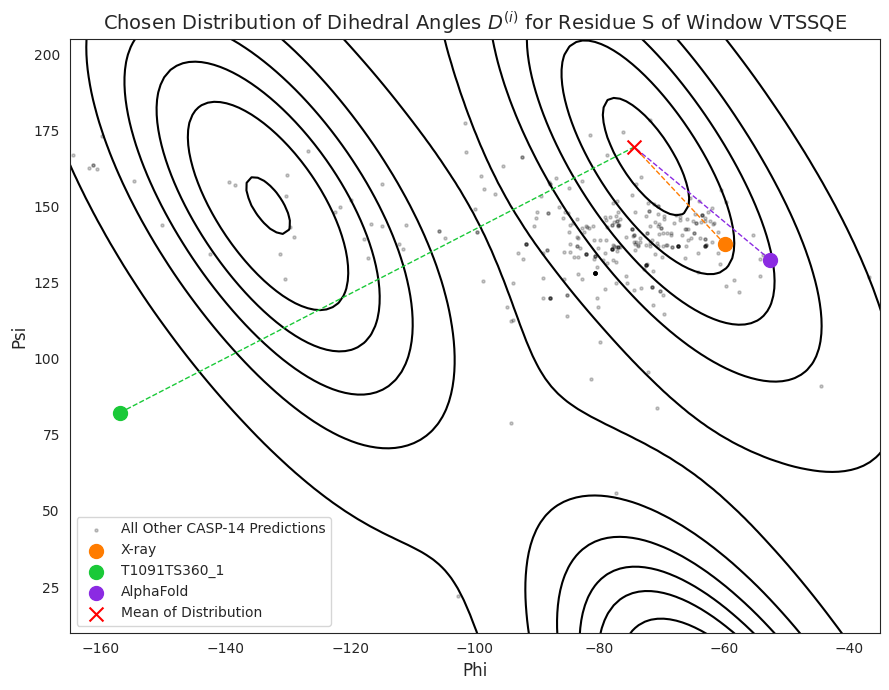

In [367]:
seq = 'VTSSQE'
id = 'T1091TS360_1'
plot_clusters_for_window(seq, id, '', bw_method=None)

Max: P(-69.38775510204081, -36.734693877551024)=4.7867158429022445e-05


/tmp/ipykernel_1615772/3162226098.py:219: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


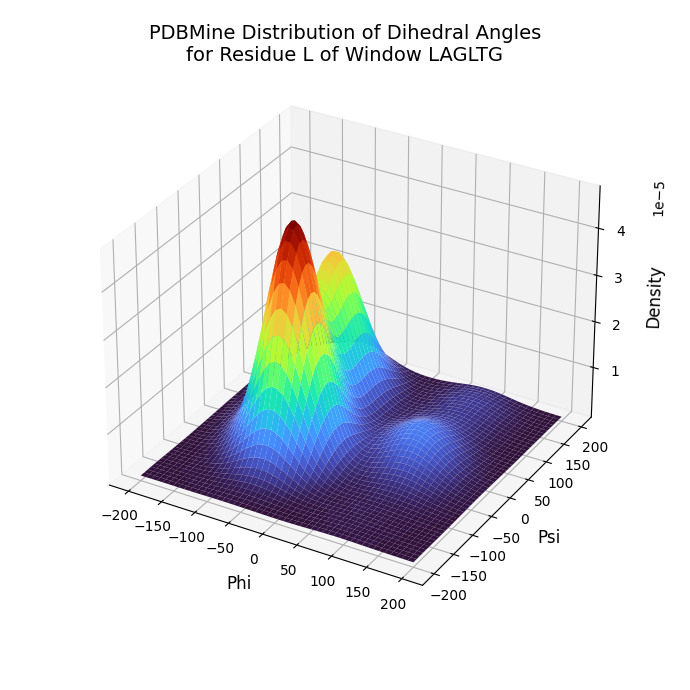

In [151]:
plot_one_dist_3d('LAGLTG')

/tmp/ipykernel_1587740/2125420362.py:364: RuntimeWarning: Mean of empty slice
  X = np.where(np.isnan(X), np.nanmean(X,axis=0), X)


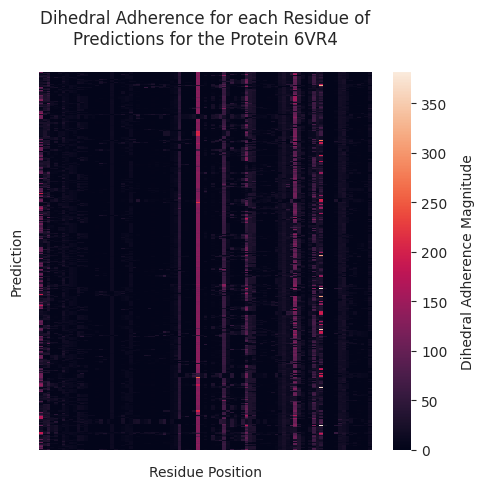

In [237]:
# Good ones: T1049, T1031, T1082

plot_heat_map()

In [295]:
both.sort_values('md_diff', ascending=False).head(10)

,pos,seq,seq_ctxt,res,phi,psi,chain,protein_id,md_alpha,Source,md_xray,md_diff
279,322,YYMRQ,YYMRQH,M,-69.956323,128.632734,A,T1091TS360_1,2694.961956,T1091TS360_1,19.018181,2675.943775
93,136,SMVGF,SMVGFG,V,-88.311919,-87.879910,A,T1091TS360_1,1875.702478,T1091TS360_1,202.939663,1672.762815
453,495,TFKPS,TFKPSD,K,-86.092144,-69.806337,A,T1091TS360_1,472.057504,T1091TS360_1,130.980652,341.076852
265,308,FRYSN,FRYSNN,Y,-172.525199,125.147444,A,T1091TS360_1,330.397758,T1091TS360_1,49.506883,280.890876
120,163,PYWPY,PYWPYE,W,-170.510538,166.990523,A,T1091TS360_1,244.842771,T1091TS360_1,13.845715,230.997056
13,56,QDDKY,QDDKYE,D,-139.611439,-20.998175,A,T1091TS360_1,286.008282,T1091TS360_1,88.245704,197.762578
620,659,RKRWR,RKRWRG,R,-132.517599,139.457737,A,T1091TS360_1,211.983119,T1091TS360_1,18.056840,193.926279
45,88,SGSMQ,SGSMQN,S,-163.215601,-177.235934,A,T1091TS360_1,192.629927,T1091TS360_1,18.123028,174.506899
101,144,IDNKK,IDNKKV,N,-48.341372,-49.003218,A,T1091TS360_1,189.112913,T1091TS360_1,33.509448,155.603465
395,437,VTSSQ,VTSSQE,S,-156.966168,82.240096,A,T1091TS360_1,178.673583,T1091TS360_1,41.693880,136.979703


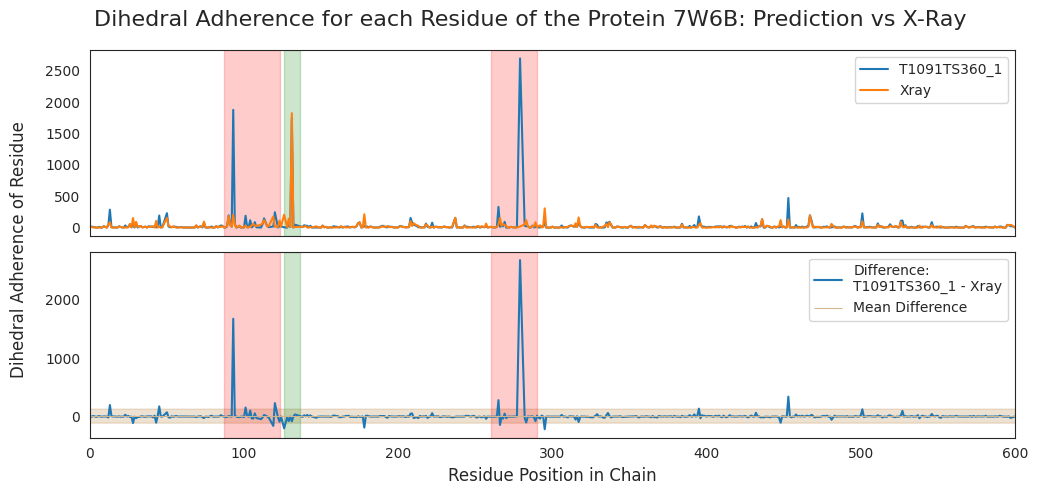

In [280]:
# Good ones: T1028TS226_2, T1091TS360_1, T1096TS259_2
id = 'T1091TS360_1'
both = plot_res_vs_md(id)